# NHDPlus and Flow Accumulation

In [10]:
from pynhd import NLDI, WaterData
import pynhd as nhd

[PyNHD](https://github.com/cheginit/pynhd) provides access to the Hydro Network-Linked Data Index ([NLDI](https://labs.waterdata.usgs.gov/about-nldi/index.html)) and the [WaterData](https://labs.waterdata.usgs.gov/geoserver/web/wicket/bookmarkable/org.geoserver.web.demo.MapPreviewPage?1) web services for navigating and subsetting [NHDPlus](https://nhdplus.com/NHDPlus) V2 database.

First, let's get the watershed geometry of the contributing basin of a USGS station using `NLDI`:

In [2]:
nldi = NLDI()
station_id = "USGS-01031500"
UT = "upstreamTributaries"
UM = "upstreamMain"

basin = nldi.getfeature_byid("nwissite", station_id, basin=True)

The `navigate_byid` class method can be used to navigate NHDPlus in both upstream and downstream of any point in the database. The available feature sources are ``comid``, ``huc12pp``, ``nwissite``, ``wade``, ``WQP``. Let's get `ComID`s of the tributaries and the main river channel in the upstream of the station.

In [3]:
args = {
    "fsource": "nwissite",
    "fid": station_id,
    "navigation": UM,
    "source": "nwissite",
    "distance": None,
}

st_main = nldi.navigate_byid(**args, url_only=True)

args["navigation"] = UT
st_trib = nldi.navigate_byid(**args)

We can get other USGS stations upstream (or downstream) of the station and even set a distance limit (in km):

In [4]:
args["distance"] = 20
st_d100 = nldi.navigate_byid(**args)

Now, let's get the [HUC12 pour points](https://www.sciencebase.gov/catalog/item/5762b664e4b07657d19a71ea):

In [5]:
args.update({
    "distance": None,
    "source" : "huc12pp",
})
pp = nldi.navigate_byid(**args)

`NLDI` only provides the flowlines' geometries and ComIDs which is useful for navigating the vector river network data. For getting the NHDPlus database we use the `WaterData` class. The WaterData web service layers are  ``nhdarea``, ``nhdwaterbody``,
``catchmentsp``, ``gagesii``, ``huc08``, ``huc12``, ``huc12agg``, and ``huc12all``.

In [6]:
wd = WaterData("nhdflowline_network")

args.update({"source" : None, "navigation": UM})
comids = nldi.navigate_byid(**args).nhdplus_comid.tolist()
flw_main = wd.byid("comid", comids)

args["navigation"] = UT
comids = nldi.navigate_byid(**args).nhdplus_comid.tolist()
flw_trib = wd.byid("comid", comids)

Let's plot the vector data:

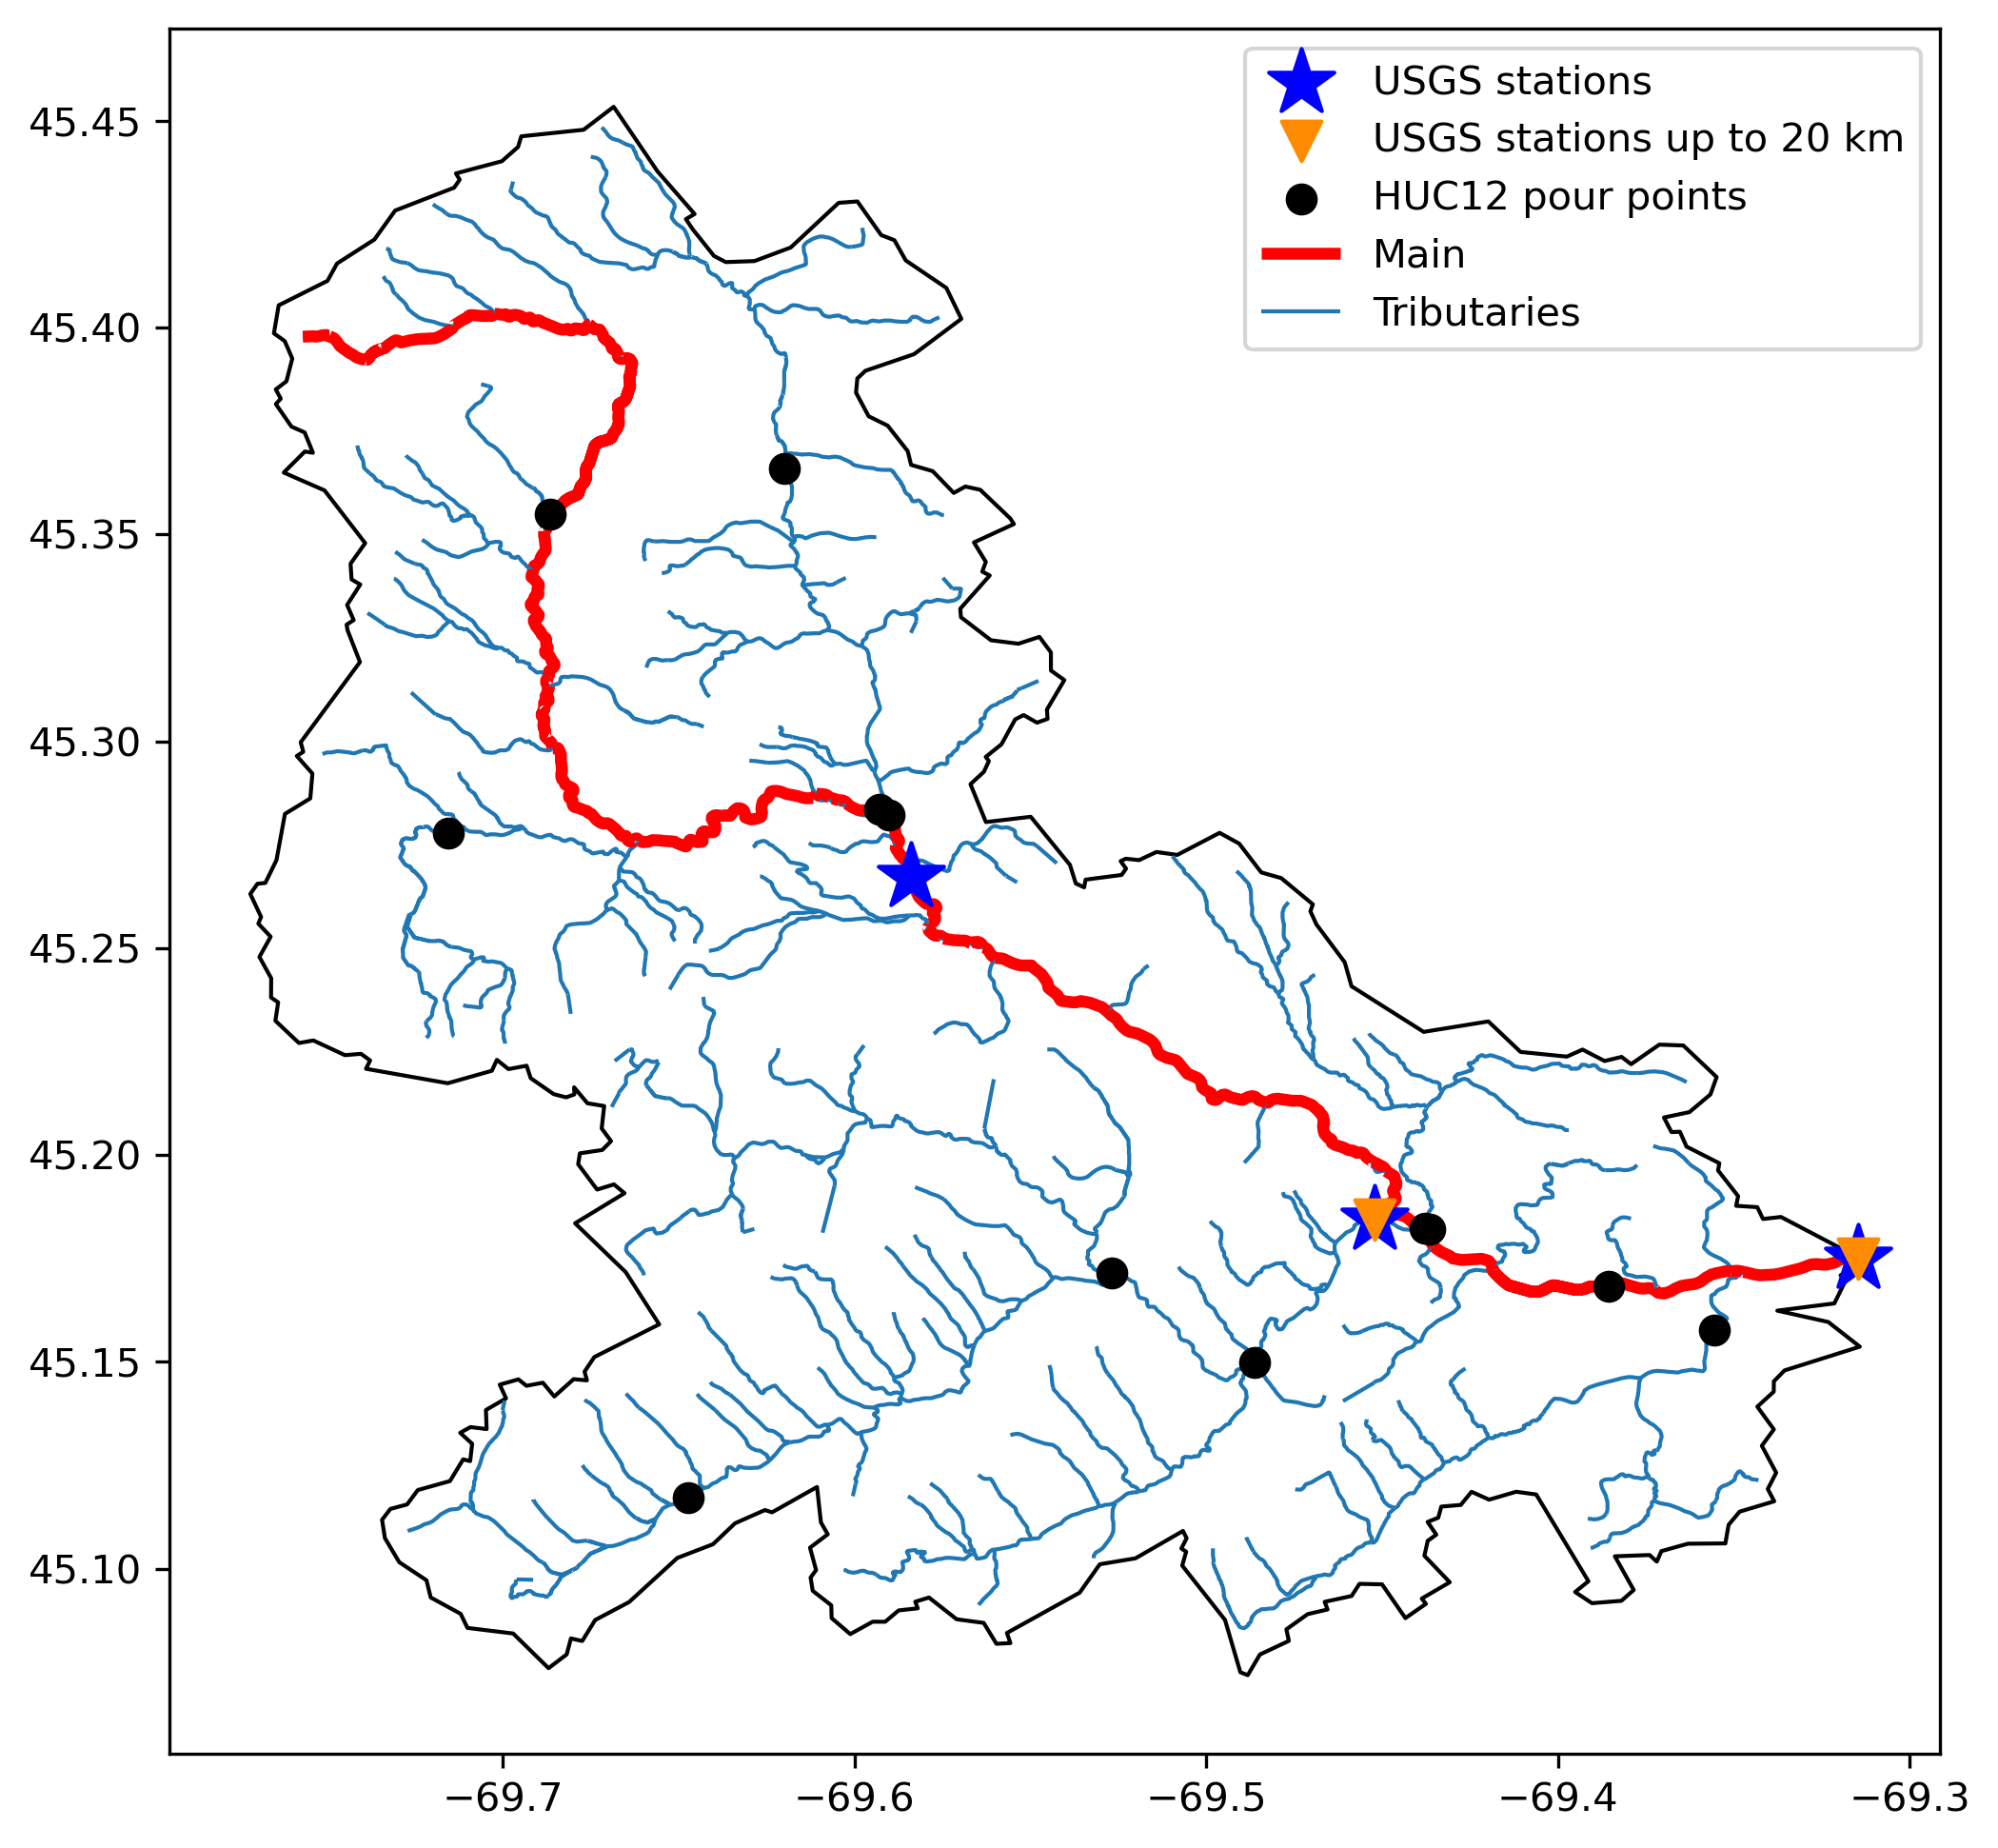

In [7]:
ax = basin.plot(facecolor="none", edgecolor="k", figsize=(8,8))
st_trib.plot(ax=ax, label="USGS stations", marker="*", markersize=300, zorder=4, color="b")
st_d100.plot(ax=ax, label="USGS stations up to 20 km", marker="v", markersize=100, zorder=5, color="darkorange")
pp.plot(ax=ax, label="HUC12 pour points", marker="o", markersize=50, color="k", zorder=3)
flw_main.plot(ax=ax, lw=3, color="r", zorder=2, label="Main")
flw_trib.plot(ax=ax, lw=1, zorder=1, label="Tributaries")
ax.legend(loc="best")
ax.set_aspect("auto")
ax.figure.set_dpi(300)

Based on topological sorting of a river network ``pynhd.vector_accumulation`` computes flow accumulation in the network. It returns a dataframe which is sorted from upstream to downstream and has a column named ``acc`` that shows the accumulated flow in each node. For demonstration purposes, lets assum the flow in each river segment is equal to the length of the river segment. Therefore, it should produce the same results as the ``arbolatesu`` variable in the NHDPlus database.

In [19]:
args = {
    "fsource": "nwissite",
    "fid": "USGS-11092450",
    "navigation": UT,
    "source": None,
    "distance": None,
}
comids = nldi.navigate_byid(**args).nhdplus_comid.tolist()
flw_trib = wd.byid("comid", comids)

flw = nhd.prepare_nhdplus(flw_trib, 0, 0, purge_non_dendritic=True)

def routing(qin, q):
    return qin + q

qsim = nhd.vector_accumulation(flw[["comid", "tocomid", "lengthkm"]], routing, "lengthkm", ["lengthkm"])
flw = flw.merge(qsim, on="comid")
diff = flw.arbolatesu - flw.acc
diff.abs().max()

1.4210854715202004e-14